## Mapping

This notebook shows how to map using the [geopandas](http://geopandas.org/) package which basically combines a pandas dataframe with a GIS shape file from which a map can be produce. There are several critical steps in this:

- First, getting geopandas properly installed. This can be hard, but I've come up with some workarounds.

- Finding a shape file. A [shapefile](https://en.wikipedia.org/wiki/Shapefile) esstinally allows us to "draw" the map. These are all over the place...simply google "what you want" + shapefile and you will probably find it. For example, last semster I found major roads for Tanzania shape file with very little effort. 

- Once these two steps have been overcome, we essentially know how to do everything else since geopandas builds on the pandas framework.

In this notebook we will aim to...
 - Aim to get familiar with the basic maping properties
 
 - Replicate the [FT graphic for NYC](https://www.instagram.com/p/BhwQPe1gWvC/?hl=en&taken-by=financialtimes).

---
### Installing Geopands

Unfortunately, this is not the smoothest process. But let me walk you through this.

#### Step 1. Check if you have geopandas. Do this by doing in the terminal command prompt
```
conda list
```

#### Step 2. If you do not have geopandas, then do the following.

**Windows users** lets try ```conda install geopandas``` which I have had recent success with. If this does not work, then try ``pip`` instead.

**MAC users** try ```pip install geopandas``` FIRST. Don't do the conda. 


In [2]:
from IPython.display import display, Image # Displays things nicely
import pandas as pd # Key tool 
import matplotlib.pyplot as plt # Helps plot
import numpy as np # Numerical operations
import os

from census import Census # This is new...
#from us import states

import fiona # Needed for geopandas to run
import geopandas as gpd # this is the main geopandas 
from shapely.geometry import Point, Polygon # also needed

##########################
# Then this stuff below allows us to make a nice inset


from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

### NYC MAP

Ok, so I types "nyc shapefiles zipcode" into google and grabbed the first one. I think it we really want to be precise, we should find zipcode tabulation areas (which are slightly different), but it is ok. This will come as a zip file. Create a folder wherever you are working and unzip the file there. **YOU NEED ALL THE FILES**. 

One thing to note about these files is that can sometimes be very large depending upon the "resolution" or how accurate the map is. Another thing to note is that this shape file also has the problem in that the "polygons" are not defined by latitued and longitude. This is a bit prolematic if we want to merge it up with other locational data. 

I grabbed the [NYC shape file from here](https://data.cityofnewyork.us/download/i8iw-xf4u/application%2Fzip). Again, take the zip file and unzip **ALL** the files into a folder or your current working directory. 

Below is how I grab the files (only works on my computer)

In [5]:
cwd = os.getcwd()

regions_shape = cwd + "\\shapefile\\ZIP_CODE_040114.shx"

regions_shape

'C:\\Users\\mwaugh\\github\\data_bootcamp_spring_2019\\mapping\\shapefile\\ZIP_CODE_040114.shx'

Now here is the basic command to get the file into python. You just point it to the `.shx` file and use the `gpd.read_file` command. Very simple.

In [145]:
nyc_map = gpd.read_file(regions_shape)

Again if this is not working. The problem is probably that you do not have **ALL** the shape files in the folder. Go back above and do this again. Now what kind of type is ``nyc_map``

In [146]:
type(nyc_map)

geopandas.geodataframe.GeoDataFrame

Then just like pandas, we can do very simmilar operations. Like look at the head....

In [149]:
nyc_map.shape

(263, 13)

And we can learn about the types...

In [14]:
nyc_map.dtypes

ZIPCODE        object
BLDGZIP        object
PO_NAME        object
POPULATION    float64
AREA          float64
STATE          object
COUNTY         object
ST_FIPS        object
CTY_FIPS       object
URL            object
SHAPE_AREA    float64
SHAPE_LEN     float64
geometry       object
dtype: object

The key feature of this is the **`geometry`** column. NEVER change the name of this. It is perserved for retaining the shape of that particular area. This is the key feature that allows us to map....within each entry of the `geometry` column, there is essentially instructions to draw lines in a way to create the boundries or shape of that local.

Other than the `geometry` column, it is essentially a standard DataFrame. This is one reason why I really like this package. Another reason is that if you can get the shape files, then you can map it.

---


### Making a map 

Very simple, we use our fig, ax approach and watch the magic happen....

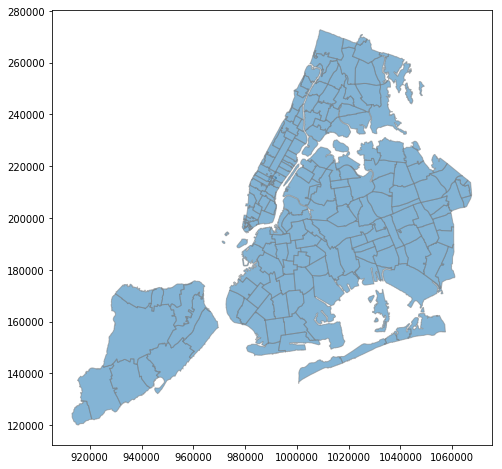

In [15]:
fig, ax = plt.subplots(figsize = (10,8))

# First create the map for the urban share

nyc_map.plot(ax = ax, # So the geopandas has a built in plot feature, we just pass our "ax to it
             edgecolor='tab:grey', # Tell it the edge color
             alpha = 0.55) # Transparent

plt.show()

**THERE IT IS!!!!!!!!!!!!!!!!!!!!!!!!!!**

This is quite amazing...very simple. The shape file that we brought in has population in it already. So what we can do is create a colorpath map where different areas are shaded with different intensities.

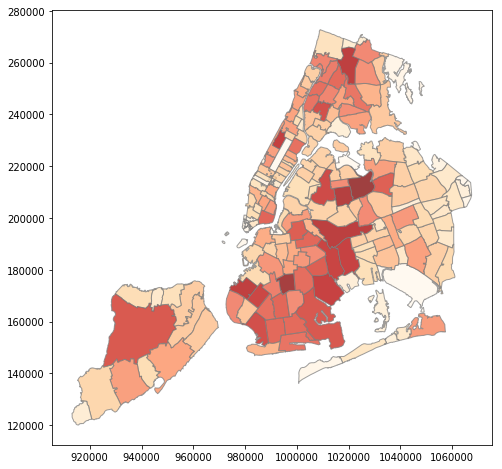

In [16]:
fig, ax = plt.subplots(figsize = (10,8))

# First create the map for the urban share

nyc_map.plot(ax = ax, edgecolor='tab:grey',
             column='POPULATION', # THIS IS NEW, it says color it based on this column
             cmap='OrRd', # This is the color map scheme https://matplotlib.org/examples/color/colormaps_reference.html
             alpha = 0.75)

plt.show()

---
### Merge it up with the CENSUS data 

Here is the process.

- Grab the zip codes from the `nyc_map` so we can then pass them through to the CENSUS API. This is what the next set of code does. 

- Clean the Census data up (e.g. change names and types). 

- Merge the Census data up with map.

- Make the map.

Grab the zip codes from the nyc_map so we can then pass them through to the CENSUS API. So we create a list, then make a big string, drop the brackets...

In [177]:
nyc_map = gpd.read_file(regions_shape)

nyc_map.ZIPCODE = nyc_map.ZIPCODE.astype(int) # we want these to look like numbers

nyc_zips = nyc_map.ZIPCODE.tolist() # Create a list

print(len(nyc_zips))

nyc_zips = "".join(str(nyc_zips)) # turn the list into a string and join everything

nyc_zips = nyc_zips[1:-1] # Take the brakets off

263


In [178]:
len(nyc_zips)

1836

In [179]:
my_api_key = '34e40301bda77077e24c859c6c6c0b721ad73fc7'
# This is my api_key

c = Census(my_api_key)
# This will create an object c which has methods associated with it.

In [180]:
code = ("NAME","B19013_001E", "B01001_001E") 
# median houshold income and population
    
zip_nyc = pd.DataFrame(c.acs5.get(code, 
                                         {'for': 'zip code tabulation area:' + nyc_zips }, year=2013))

# Then noteice what 'zip code tabulation area:' + nyc_zips does, it creats a big long string
# for which we can pass to the api and grab the data for each location

zip_nyc.info()

zip_nyc.rename(columns={code[1]:"Income", code[2]: "Population"}, inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209 entries, 0 to 208
Data columns (total 4 columns):
B01001_001E                 209 non-null float64
B19013_001E                 209 non-null float64
NAME                        209 non-null object
zip code tabulation area    209 non-null object
dtypes: float64(2), object(2)
memory usage: 6.6+ KB


In [98]:
zip_nyc.head(50)

#zip_nyc.replace([0.0,-666666666.0], 0.0, inplace = True)

#zip_nyc[zip_nyc["Income"] == 0.0]["Income"] = np.nan

#zip_nyc[zip_nyc["Income"] == -666666666.0]["Income"] = np.nan

#zip_nyc[zip_nyc["Income"] == 0.0]["Population"] = np.nan

This will clean up the names, and the types. Note that we want to merge on `ZIPCODE` so we will want to match up the column names and the types in both dataframes so they can be merged.

In [116]:
zip_nyc[zip_nyc["Population"] == -666666666.0]["Income"] 

Series([], Name: Income, dtype: float64)

In [181]:
#zip_nyc['log_Income'] = np.log(zip_nyc["Income"]) 

# Im going to work with log income as this will show the differences better.

#zip_nyc['Population'] = zip_nyc["Population"]

zip_nyc['ZIPCODE'] = zip_nyc['zip code tabulation area'].astype(int)

#zip_nyc["Population"]  = zip_nyc['Population'].astype(float)

This is the merge command. Works just like a Dataframe. The `left` part is important as we want a contigouis map, not missing pieces.

In [182]:
nyc_map  = nyc_map.merge(zip_nyc, on='ZIPCODE', how = "left", indicator = True)



In [187]:
nyc_map[nyc_map._merge == "left_only"]["Population"] = 0

C:\Users\mwaugh\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [197]:
nyc_map["Population"].replace(np.nan,0.0, inplace = True)


The issue is that the color map will not handel np.nan values, so we will replace them with a zero. 

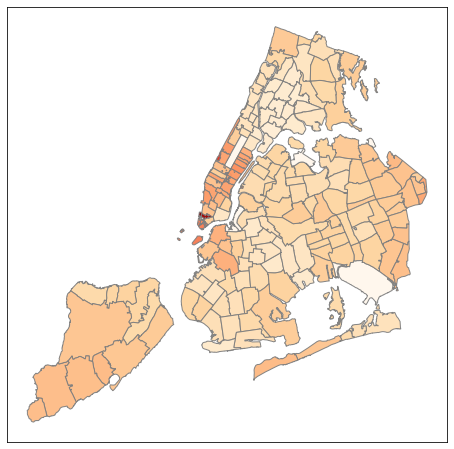

In [199]:
fig, ax = plt.subplots(figsize = (10,8))

# First create the map for the urban share

nyc_map.plot(ax = ax, edgecolor='tab:grey', column="Income", cmap='OrRd', alpha = 0.95)

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

#axins.plot()

plt.show()

Ok, this is really cool. The interesting thing is the dark red part in downtown. Can we have an inset to the big map that zooms in there....YES! Belwo I show you how to do this...

C:\Users\mwaugh\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\mwaugh\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)
C:\Users\mwaugh\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\colors.py:512: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


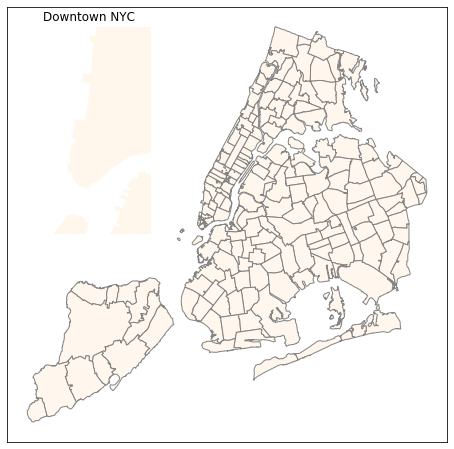

In [95]:
fig, ax = plt.subplots(figsize = (10,8))

# First create the map for the urban share

nyc_map.plot(ax = ax, edgecolor='tab:grey', column='Income', cmap='OrRd', alpha = 0.95)

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

##########################################################################################################
# This is the new part. It creats an "ax wihin an ax". We generate this by the following commands.

axins = zoomed_inset_axes(ax, # The original ax
                          4, # zoom level
                          loc=2, # location
                          borderpad=2)  # space around it relative to figure

nyc_map.plot(ax = axins, column='Income', cmap='OrRd')

# Then create the map in the "insice ax" or axins. Note, that you do not
# need to keep the colering or the income, you could have the inset 
# be population or what ever else.

# then the stuff below picks the box for the inset to cover. I
# I kind of just eyballed this untill I zoomed into what I wanted

# Note the "axins" object really just works like the ax

x1, x2, y1, y2 = 975000, 987000, 190000, 210000
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)

axins.set_title("Downtown NYC")
# Make a title.

mark_inset(ax, axins, loc1=3, loc2=1, fc="none", alpha = 0.5)
# This then creates the lines that marks where the inset comes from

# Make it look nice
axins.spines["right"].set_visible(False)
axins.spines["top"].set_visible(False)
axins.spines["left"].set_visible(False)
axins.spines["bottom"].set_visible(False)

#axins.Tick.remove()

axins.get_xaxis().set_visible(False)
axins.get_yaxis().set_visible(False)



plt.show()

WOW!!! This is awesome. Shows really clearly what is going on with downtown NYC....

---

### US County Map

In [28]:
cwd = os.getcwd()

regions_shape = cwd + "\\shape_files\\UScounties\\cb_2017_us_county_500k.shx"

In [29]:
us_map = gpd.read_file(regions_shape)

In [30]:
type(us_map)

geopandas.geodataframe.GeoDataFrame

In [31]:
us_map.head()

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry
0,01,005,00161528,0500000US01005,01005,Barbour,06,2292144656,50538698,"POLYGON ((-85.74803199999999 31.619181, -85.74..."
1,01,023,00161537,0500000US01023,01023,Choctaw,06,2365869837,19144469,"POLYGON ((-88.47322699999999 31.893856, -88.46..."
2,01,035,00161543,0500000US01035,01035,Conecuh,06,2201948618,6643480,"POLYGON ((-87.42720399999999 31.26436, -87.425..."
3,01,051,00161551,0500000US01051,01051,Elmore,06,1601762124,99965171,"POLYGON ((-86.41333499999999 32.750591, -86.37..."
4,01,065,00161558,0500000US01065,01065,Hale,06,1667907107,32423356,"POLYGON ((-87.870464 32.762442, -87.868184 32...."


In [32]:
us_map.set_index("STATEFP", inplace = True)

In [36]:
us_map.drop(["02","03","15","43","14","79","78","72","69","60","66"], inplace = True)

In [37]:
us_map.index.unique()

Index(['01', '04', '05', '06', '08', '09', '11', '12', '13', '16', '17', '18',
       '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30',
       '31', '34', '35', '36', '37', '38', '39', '40', '41', '42', '45', '46',
       '47', '48', '49', '51', '53', '54', '55', '56', '10', '32', '33', '44',
       '50'],
      dtype='object', name='STATEFP')

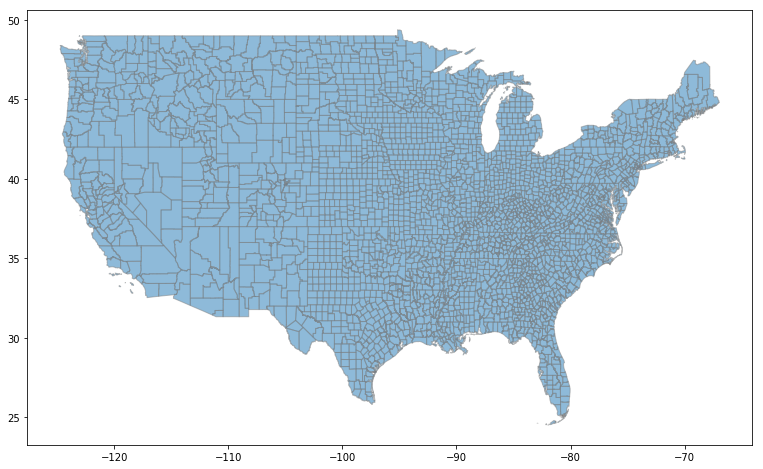

In [38]:
fig, ax = plt.subplots(figsize = (13,8))

# First create the map for the urban share

us_map.plot(ax = ax, edgecolor='tab:grey', alpha = 0.5)

plt.show()